In [29]:
# Import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from model import ConvolutionalAutoEncoder
from cae_classifier import CAEClassifier
from data import data_transforms, validation_data_transforms


In [22]:
# Set up your device 
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [23]:
# import the MNIST test set 
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)

In [24]:
# load the test set 
x_test, _ = list(test_loader)[0]
batch_size = x_test.shape[0]
x_test = x_test.view(batch_size, -1)

In [24]:
len(test_loader.dataset)

10000

In [6]:
# instantial the model and load the weights
input_dim = 28*28*1
model = SparseAutoEncoder(input_dim)
model.load_state_dict(torch.load('test_SAE/test/sparse_test_30.pth', map_location='cpu'))

RuntimeError: Error(s) in loading state_dict for SparseAutoEncoder:
	size mismatch for encoder.0.weight: copying a param with shape torch.Size([256, 784]) from checkpoint, the shape in current model is torch.Size([1024, 784]).
	size mismatch for encoder.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([784, 256]) from checkpoint, the shape in current model is torch.Size([784, 1024]).

In [34]:
encode_imgs = model.encoder(x_test)
decode_imgs = model.decoder(encode_imgs)

In [35]:
# print the shape of encode imgs and decode imgs
print('encode imgs:', encode_imgs.size())
print('decode imgs:', decode_imgs.size())

encode imgs: torch.Size([128, 256])
decode imgs: torch.Size([128, 784])


NameError: name 'decode_imgs' is not defined

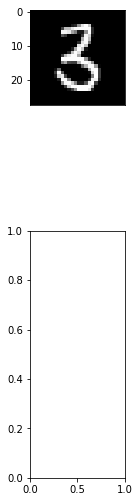

In [7]:
# plot the figure
n = 10
plt.figure(figsize=(20,10))

for i in range(n):
    # plot the test image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].detach().numpy().reshape((28, 28)), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(True)
    
    # plot the decoded image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decode_imgs[i].detach().numpy().reshape((28, 28)), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(True)

In [8]:
# new test

In [9]:
input_dim = 96*96*3 # need to change
fc1_input_features = 256
n_classes = 10

In [10]:
model = SparseAutoEncoder(input_dim)
model.load_state_dict(torch.load('test_SAE/classify/classify_train/sparse_ae_model_6.pth', map_location='cpu'))

In [14]:
# import the data loader
data_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder('../../data/ssl_data_96/supervised/train', transform=data_transforms),
        batch_size=128, shuffle=True, num_workers=1)

In [18]:
x_test, _ = list(data_loader)[0]
batch_size = x_test.shape[0]
x_test = x_test.view(128, -1)

KeyboardInterrupt: 

In [16]:
encode_imgs = model.encoder(x_test)
decode_imgs = model.decoder(encode_imgs)

In [17]:
print('encode imgs:', encode_imgs.size())
print('decode imgs:', decode_imgs.size())

encode imgs: torch.Size([128, 1024])
decode imgs: torch.Size([128, 27648])


In [37]:
sae_model = SparseAutoEncoder(input_dim).to(device)
sae_model.load_state_dict(torch.load('test_SAE/classify/classify_train/sparse_ae_model_6.pth', map_location='cpu'))

In [40]:
sae_model.encoder[0].weight.size()

torch.Size([256, 784])

In [41]:
torch.Tensor(sae_model.encoder[0].weight.detach())

tensor([[0.0717, 0.0606, 0.0991,  ..., 0.0682, 0.0435, 0.1017],
        [0.0534, 0.0580, 0.0401,  ..., 0.0711, 0.0597, 0.0248],
        [0.0183, 0.0299, 0.0459,  ..., 0.0555, 0.0165, 0.0277],
        ...,
        [0.1093, 0.1003, 0.1000,  ..., 0.0693, 0.0601, 0.0594],
        [0.0208, 0.0568, 0.0403,  ..., 0.0174, 0.0197, 0.0556],
        [0.0369, 0.0540, 0.0486,  ..., 0.0414, 0.0773, 0.0789]])

In [45]:
sae_classifier = SAEClassifier(input_dim, fc1_input_features, n_classes).to(device)
sae_classifier.initialize_from_sae(sae_model)
sae_classifier.encoder[0].weight.size()

torch.Size([256, 784])

In [47]:
sae_classifier.encoder[0].weight.size()

torch.Size([256, 784])

In [16]:
from data import data_transforms, validation_data_transforms


In [15]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self, fc_input_features):
        super(ConvolutionalAutoEncoder, self).__init__()
        self.fc_input_features = fc_input_features
        
        self.conv1 = nn.Conv2d(3,16,5,1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.conv2 = nn.Conv2d(16,32,5,1)
        self.bn2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.conv3 = nn.Conv2d(32,64,4,1)
        self.bn3 = nn.BatchNorm2d(64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=1, return_indices=True)
        
        # 17*17*64
        self.fc1 = nn.Linear(self.fc_input_features, 8192)
#         self.fc2 = nn.Linear(16384, 8192)
#         self.fc3 = nn.Linear(8192, 16384)
        self.fc2 = nn.Linear(8192, self.fc_input_features)


        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=1)
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    
        self.deconv1 = nn.ConvTranspose2d(64,32,4,1)
        self.deconv2 = nn.ConvTranspose2d(32,16,5,1)
        self.deconv3 = nn.ConvTranspose2d(16,3,5,1)

    def forward(self, x):
        # encode
        x = self.relu(self.bn1(self.conv1(x)))
        x, poolIdx1 = self.maxpool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x, poolIdx2 = self.maxpool2(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x, poolIdx3 = self.maxpool3(x)
        print('x shape', x.size())
        x = x.view(x.size(0), -1)
        print('x shape', x.size())
        encoded = self.relu(self.fc1(x))
#         encoded = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(encoded))
        x = self.relu(self.fc2(encoded))
        print('x shape', x.size())
        x = x.view(-1, 64, 17, 17)
        x = self.unpool1(x, poolIdx3)
        x = self.relu(self.bn2(self.deconv1(x)))
        x = self.unpool2(x, poolIdx2)
        x = self.relu(self.bn1(self.deconv2(x)))
        x = self.unpool3(x, poolIdx1)
        decoded = self.relu(self.deconv3(x))
        return decoded, encoded

In [16]:
randn = torch.randn(128, 3, 96, 96)

In [17]:
model = ConvolutionalAutoEncoder(17*17*64)

In [18]:
model

ConvolutionalAutoEncoder(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18496, out_features=8192, bias=True)
  (fc2): Linear(in_features=8192, out_features=18496, bias=True)
  (unpool1): MaxUnpool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
  (unpool2): MaxUnpool2d(kernel_siz

In [19]:
x = model(randn)

x shape torch.Size([128, 64, 17, 17])
x shape torch.Size([128, 18496])
x shape torch.Size([128, 18496])


In [28]:
m = nn.BatchNorm2d(100)
input = torch.randn(20, 100, 35, 45)
m.bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], requires_grad=True)

In [ ]:
pretrained_dict = torch.load(args.pth, map_location=args.device)